In [0]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

In [0]:
# imports
from google.colab import drive
from google.colab import auth
from googleapiclient.discovery import build
from google.colab.patches import cv2_imshow
from google.colab import files

# user authentication
auth.authenticate_user()
drive_service = build('drive', 'v3')

# mounts
MOUNT = True
UNMOUNT = False

# mounting drive
if MOUNT:
  drive.mount('/content/drive')

################################################################################
import os
import numpy as np
import json
import cv2
import tqdm
import random
import matplotlib.pyplot as plt

from detectron2 import model_zoo
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# global constants and functions that are platform depenedent
LOAD_DATASET = False
COLAB = True
LOCAL = False
platform = "./" if LOCAL else "/content/drive/My Drive/Colab Notebooks/Snake-Detector-v2/"
def cv2_show_img(title, img):
  """ 
  A wrapper for platform dependent cv2.imshow function
  """
  if COLAB:
    cv2_imshow(img)
  else:
    cv2.imshow(title, img)
  cv2.waitKey()
  cv2.destroyAllWindows()

# global constants for labels
labels_dict = {0: "snake", 1: "background"}
HEIGHT = 385
WIDTH = 510
CHANNELS = 3

# function to properly create a Detectron2 Dataset
def detectron2_dataset(path):
    """
    Returns a list[dict] to load into a standard Dataset as specified by 
    https://detectron2.readthedocs.io/tutorials/datasets.html
    
    Params: 
        path = path to directory of images and labels 
        (aka train or test directory)
    """

    # get JSON annotations and images and create list to be returned
    json_files = os.listdir(path + "labels/") 
    image_files = os.listdir(path + "images/")
    std_list = []
   
    # iterate through annotation files
    for json_file in json_files:
        # create dict for image
        image = {}

        # get image name (will be used as image id)
        image_id = json_file[ : json_file.find(".json")]
        image_name = image_id + ".jpg"

        # open JSON file
        annotations = None
        with open(path + "labels/" + json_file) as f:
            annotations = json.load(f)

        # load in standard parameters
        image["file_name"] = path + "images/" + image_name
        image["height"] = annotations["imageHeight"]
        image["width"] = annotations["imageWidth"]
        image["image_id"] = image_id
        
        # load in annotations per shape instance, format of list[dict]
        objs = []
        for shape in annotations["shapes"]:
            # create dict for each box/shape
            obj = {}

            # get polygon and point information
            polygon = shape["points"]
            px = [point[0] for point in polygon]
            py = [point[1] for point in polygon]

            # load fields
            obj["bbox"] = [min(px), min(py), max(px), max(py)]
            obj["bbox_mode"] = BoxMode.XYXY_ABS
            obj["category_id"] = 0
            obj["segmentation"] = [[axis for point in polygon for axis in point]]

            # append obj
            objs.append(obj)

        # add "annotations" field to image
        image["annotations"] = objs
        std_list.append(image)

    # return the std_list
    return std_list


# function to verify if DatasetCatalog is loaded correctly
def test_dataset(path):
    """
    Test if detectron2_dataset function is correct.

    Params:
        path = path to directory of images and labels 
        (aka train or test directory)
    """
    # get train/test type from path
    img_type = "train" if path.find("train") != -1 else "test"

    # get dataset and load metadata
    data = detectron2_dataset(path)
    DatasetCatalog.register("snake_" + img_type, lambda d=img_type: detectron2_dataset(platform + img_type + "/"))
    MetadataCatalog.get("snake_" + img_type).set(thing_classes=["snake"])
    snake_metadata = MetadataCatalog.get("snake_" + img_type)

    # get 3 random images and check if they're correct
    for d in data:
        img = cv2.imread(d["file_name"])
        visualizer = Visualizer(img[:, :, ::-1], metadata=snake_metadata, scale=0.7)
        vis = visualizer.draw_dataset_dict(d)
        cv2_show_img("Sneks", vis.get_image()[:, :, ::-1])

# Extended trainer class that allows evaluation
class SnakeTrainer(DefaultTrainer):
    """
    Class that implements the build_evaluator function,
    allows for custom evaluation
    """
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            os.makedirs(platform + "eval", exist_ok=True)
            output_folder = platform + "eval"
        return COCOEvaluator(dataset_name, cfg, False, output_folder)

# load training dataset
if LOAD_DATASET:
    DatasetCatalog.register("snake_train", lambda d="train/": detectron2_dataset(platform + d))
    MetadataCatalog.get("snake_train").set(thing_classes=["snake"])

# Configs for Faster R-CNN architecture
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("snake_train", )
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 0                  # threads for data loading
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001                     # change me
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.STEPS = (1000, 1500, 2000)
cfg.SOLVER.GAMMA = 0.05
cfg.SOLVER.MAX_ITER = 2000                      # may need to increase later
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64   # may need to increase later
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1             # 1 class (snake)

# load outputs into "output" directory
cfg.OUTPUT_DIR = platform + "output/"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = SnakeTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

# load test dataset
# NOTE: had some weird problem where it was training on test dataset
if LOAD_DATASET:
    DatasetCatalog.register("snake_test", lambda d="test/": detectron2_dataset(platform + d))
    MetadataCatalog.get("snake_test").set(thing_classes=["snake"])

################################################################################

# unmount drive
if UNMOUNT:
  drive.flush_and_unmount()

print("All changes saved in Google Drive.")


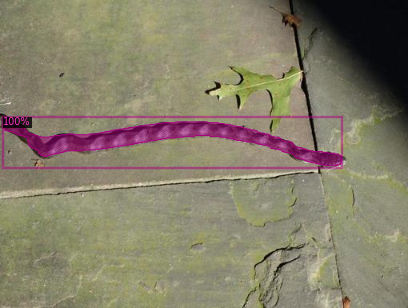

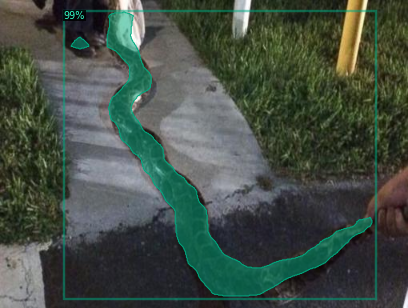

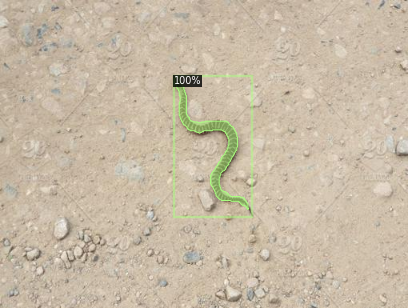

In [104]:
import os
import numpy as np
import json
import cv2
import random

from detectron2 import model_zoo
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# load model and make predictions
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.95
cfg.DATASETS.TEST = ("snake_test", )
snake_metadata = MetadataCatalog.get("snake_test")
predictor = DefaultPredictor(cfg)

# display some test results
eval_dataset = detectron2_dataset(platform + "test/")
for d in random.sample(eval_dataset, 3):
    img = cv2.imread(d["file_name"])  #cv2.imread(platform + "temp/" + d) 
    outputs = predictor(img)
    
    v = Visualizer(img[:, :, ::-1], metadata=snake_metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_show_img("Prediction", v.get_image()[:, :, ::-1])